# Generative Radio Channel with Synthetic Data

This notebook serves as the synthetic dataset generation. I try to create 1000 samples. 800 for training, 100 for validation, and 100 for testing. A sample room is provided as an SVG made with Inkscape. I did this so that I have something to work with when exploring FSPL and Multi-Wall models. Also so that we can arbitrarily create rooms using Inkscape, save to SVG, and try out our glorious model.

Based on COST INTERACT paper

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/ai_in_wireless`
Precompiling packages...
   1363.3 ms  ✓ Plots → IJuliaExt
  1 dependency successfully precompiled in 6 seconds. 510 already precompiled.


In [2]:
using Plots
using Printf: @printf, @sprintf
using ProgressMeter

In [3]:
const DEFAULT_FREQ = 2.4f0 # GHz
const PIXELS_PER_METER = 3.0f0

include("map.jl")
include("signals.jl")

normalize_radio_data (generic function with 1 method)

Suppose that we have three transmitter locations:
1. $(20.0, 30.0)$
2. $(4.0, 9.0)$
3. $(98.0, 78.0)$

room = Room{Float32}((256.0f0, 256.0f0), Line{2, Float32}[Line(Float32[109.38626, 222.7764] => Float32[109.38626, 239.04218]), Line(Float32[109.38626, 239.04218] => Float32[32.501347, 239.04218]), Line(Float32[32.501347, 239.04218] => Float32[32.501347, 26.90972]), Line(Float32[32.501347, 26.90972] => Float32[232.05266, 26.90972]), Line(Float32[232.05266, 26.90972] => Float32[232.05266, 239.04218]), Line(Float32[232.05266, 239.04218] => Float32[149.92558, 239.04218]), Line(Float32[149.92558, 239.04218] => Float32[149.92558, 222.61678]), Line(Float32[149.92558, 222.61678] => Float32[109.38626, 222.7764]), Line(Float32[40.341927, 33.85509] => Float32[52.203564, 33.85509]), Line(Float32[52.203564, 33.85509] => Float32[52.203564, 44.728264]), Line(Float32[52.203564, 44.728264] => Float32[40.40371, 44.728264]), Line(Float32[40.40371, 44.728264] => Float32[40.341927, 33.85509]), Line(Float32[55.92876, 33.952244] => Float32[67.79039, 33.952244]), Line(Float32[67.79039, 33.952244] => Float32[6

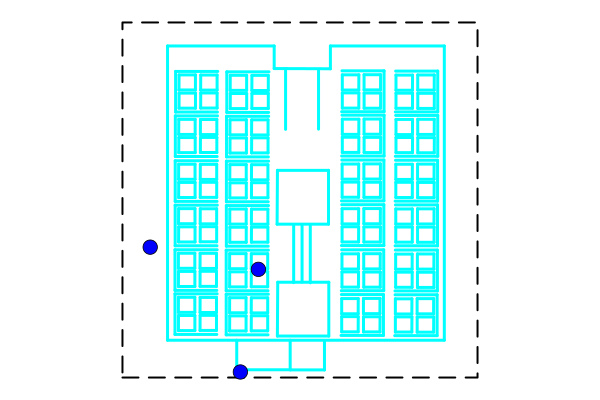

In [4]:
transmitters = Point{2, Float32}[
    Point2f(20.0, 94.0),
    Point2f(85.0, 4.0),
    Point2f(98.0, 78.0),
]

room = loadroom("FloorPlan.svg"; transmitters = transmitters)
@show room
p = plotroom(room)

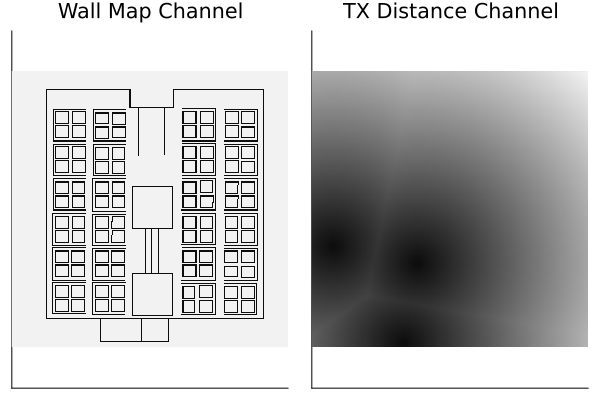

In [5]:
rs = rasterize(room)
rs_plot1 = heatmap(abs.(1 .- rs[:, :, 1])', 
    c = :grays, 
    aspect_ratio = :equal, 
    title = "Wall Map Channel",
    axis=nothing,
    ticks=nothing,
    legend=nothing,
)

rs_plot2 = heatmap(rs[:,:,2]', 
    c = :grays, 
    aspect_ratio = :equal, 
    title = "TX Distance Channel",
    axis=nothing,
    ticks=nothing,
    legend=nothing,
)

plot(rs_plot1, rs_plot2)

### Free Space Path Loss

Let the receiver be $R = (x_r, y_r)$ and transmitters be $T_i = (x_i, y_i)$. 

The euclidean distance from the receiver to each transmitter $i$ is
$$
d_i = \sqrt{(x_r - x_i)^2 + (y_r - y_i)^2}
$$

So the FSPL (from lecture slides) for each transmitter is
$$
L_{i,\text{dB}} = 20\log_{10} f + 20\log_{10} d + 32.45
$$
where $f$ is the signal frequency in Gigahertz

In [6]:
rx = Point2f(30.0f0, 56.0f0)
fspl(Point2f(20.0f0, 94.0f0), rx)

62.39827270507813

In [7]:
fspl(room, rx)

3-element Vector{Float64}:
 62.39827270507813
 68.0925895690918
 67.5943099975586

In [8]:
hmap = fspl_map(room)

256×256×3 Array{Float32, 3}:
[:, :, 1] =
 70.059   69.9689  69.8779  69.786   …  74.6013  74.655   74.7084  74.7614
 70.0412  69.9507  69.8593  69.767      74.595   74.6488  74.7023  74.7554
 70.0242  69.9334  69.8416  69.7489     74.5891  74.643   74.6965  74.7497
 70.0081  69.917   69.8249  69.7318     74.5835  74.6374  74.691   74.7443
 69.993   69.9015  69.8091  69.7156     74.5782  74.6322  74.6859  74.7392
 69.9788  69.887   69.7942  69.7005  …  74.5733  74.6273  74.681   74.7344
 69.9655  69.8734  69.7804  69.6863     74.5687  74.6228  74.6765  74.73
 69.9532  69.8608  69.7675  69.6732     74.5644  74.6186  74.6724  74.7259
 69.9418  69.8492  69.7556  69.661      74.5605  74.6147  74.6685  74.7221
 69.9314  69.8386  69.7448  69.6499     74.5569  74.6111  74.665   74.7186
  ⋮                                  ⋱                              ⋮
 78.3389  78.3256  78.3124  78.2994     79.3916  79.4095  79.4275  79.4454
 78.3715  78.3583  78.3453  78.3323     79.4172  79.435   79.4529 

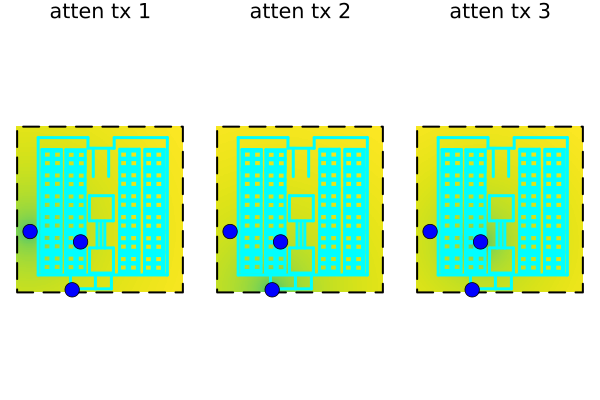

In [9]:
heatmap_plots = [
    plot_discrete_heatmap(room, hmap[:, :, i]; title = @sprintf("atten tx %d", i))
    for i ∈ 1:length(room.transmitters)
]

plot(heatmap_plots..., layout=(1, 3))

Heatmap when considering which TX is used by the RX based on attenuation

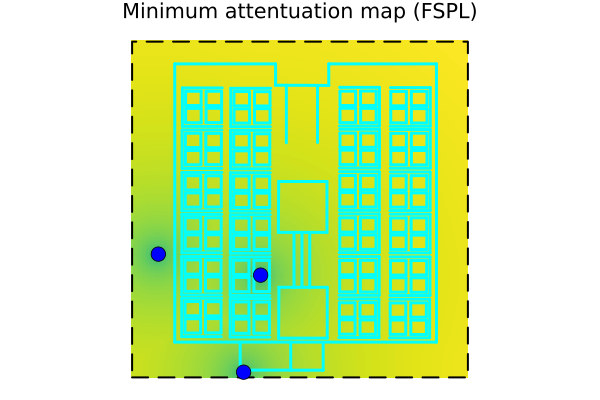

In [10]:
plot_discrete_heatmap(room, minimum(hmap, dims=3)[:, :, 1]; title="Minimum attentuation map (FSPL)")

### Multi-Wall Model

**Source**: https://thesai.org/Downloads/Volume12No4/Paper_94-Integrating_Cost_231_Multiwall_Propagation.pdf

To create the ground truth for the model, we make use of [Multi-Wall Model](https://thesai.org/Downloads/Volume12No4/Paper_94-Integrating_Cost_231_Multiwall_Propagation.pdf). This considers obstacles around the transmitter.

$$
L_{MW} = L_{FSL}(d) + \sum_{i=1}^N k_{wi}L_{wi} + k_fL_f
$$

where
* $L_{FSL}(d)$ - FSPL dependent on the distance $d$ and frequency $f$ (Given above)
* $N$ - Total number of different wall types
* $k_{wi}$ - number of walls of type $i$ that the direct signal path intersects.
* $L_{wi}$ - Attenuation factor (loss in dB) for a wall of type $i$
* $k_fL_f$ - Loss due floors due to multiple levels.

Since we only have 2D environment, then $k_fL_f=0$. Furthermore, suppose that all walls are concrete walls. The Cost 231 paper says that the attenuation for this type of wall will be 12 dB (assuming frequency of 2.4 GHz).

This greatly simplifies our multi-wall function to:

$$
L_{i,MW} = L_{i,\text{dB}}(d) + 12k
$$

where $k$ is the number of walls that intersects the ray between the TX and the RX.

In [11]:
count_walls(room, Point2f(50.0, 50.0))

3-element Vector{Int64}:
 5
 7
 9

In [12]:
mw_hmap = multiwall_heatmap(room; σ=3.0)

256×256×3 Array{Float32, 3}:
[:, :, 1] =
  70.9473   68.2216   67.6277   72.9523  …   78.9331   73.48     77.3924
  66.464    66.5642   73.278    68.6504      75.5158   75.4756   74.1722
  65.822    73.0977   74.8679   71.3589      79.5397   78.0363   70.1049
  69.401    72.931    69.7909   64.1547      69.0879   78.2074   74.1737
  67.3958   65.7811   75.793    65.6451      76.0543   74.5117   72.4888
  71.8784   66.4919   69.194    67.6893  …   77.4233   78.0592   75.0233
  68.7559   72.9462   67.9005   66.6751      73.0615   74.2963   74.057
  68.8592   72.1312   73.0464   73.2777      70.7429   78.559    77.0619
  71.5866   68.0586   67.9271   65.4514      73.2162   77.5042   77.4775
  72.1418   71.3613   73.3919   72.4341      78.9288   72.8929   71.4701
   ⋮                                     ⋱                        ⋮
 304.683   309.127   304.847   319.082      392.092   416.585   405.343
 308.842   309.009   317.943   320.522      401.807   410.806   418.259
 308.348   307.773

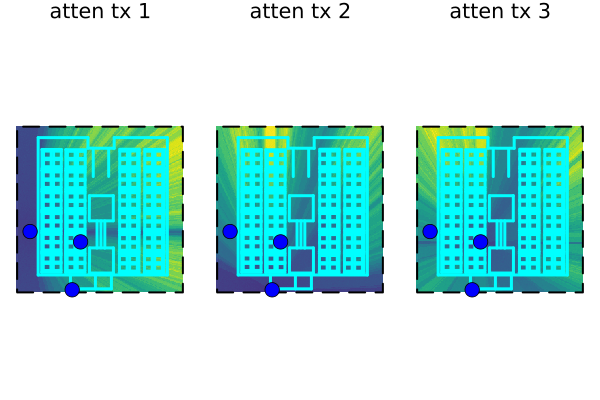

In [13]:
heatmap_plots = [
    plot_discrete_heatmap(room, mw_hmap[:, :, i]; title = @sprintf("atten tx %d", i))
    for i ∈ 1:length(room.transmitters)
]

plot(heatmap_plots..., layout=(1, 3))

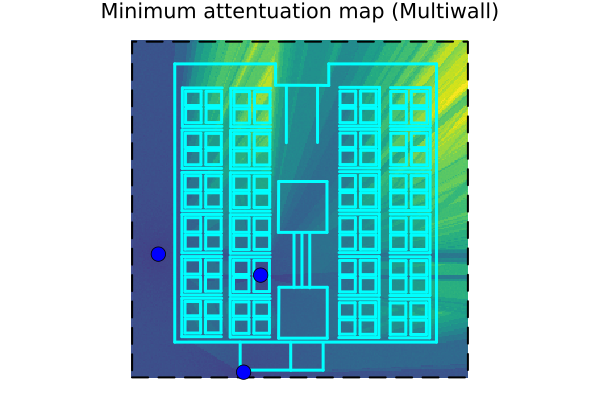

In [14]:
plot_discrete_heatmap(room, minimum(mw_hmap, dims=3)[:, :, 1]; title="Minimum attentuation map (Multiwall)")

The dataset was generated using the following command:

```bash
julia --project=$(pwd) --threads $(nproc) gendataset.jl
```

and the serialized dataset was loaded to `dataset/` directory